### Libraries

In [1]:
import pickle
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import networkx as nx
import pylab as plt
from pgmpy.inference import VariableElimination
import pdb
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, accuracy_score

### Preparing Training Data

In [2]:
# initial_state_dist = np.load('../initial_state_dist.npy')
# initial_state_dist.shape

In [3]:
#Load the processed and normalized  dataset 
import pickle
with open('../MS_normalized_df.pkl', 'rb') as f:
    data_full = pickle.load(f)

In [4]:
data_full

,Patient_ID,Gender,Age,Daytime_Interval,Patient_Interval_Number,Pain_Score,Action_Pain,Fatigue_Score,Action_Fatigue,Last_Activitybout_State,Current_Activitybout_Action,EOD_PAW,Action_PAW
0,1001,Female,Between 30 to 60,Wake,1,Higher,Recorded,Normal,Recorded,Not Recorded,Higher,None,None
1,1001,Female,Between 30 to 60,Morning,2,Lower,Recorded,Lower,Recorded,Higher,Normal,None,None
2,1001,Female,Between 30 to 60,Afternoon,3,Higher,Recorded,Normal,Recorded,Normal,Higher,None,None
3,1001,Female,Between 30 to 60,Evening,4,Higher,Recorded,Higher,Recorded,Higher,Lower,None,Recorded
4,1001,Female,Between 30 to 60,Bed,5,Normal,Recorded,Higher,Recorded,Lower,Lower,Normal,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3740,1110,Female,Between 30 to 60,Wake,31,Not Recorded,Recorded,Not Recorded,Recorded,Higher,Lower,None,None
3741,1110,Female,Between 30 to 60,Morning,32,Lower,Recorded,Higher,Recorded,Lower,Lower,None,None
3742,1110,Female,Between 30 to 60,Afternoon,33,Higher,Not Recorded,Normal,Not Recorded,Lower,Higher,None,None
3743,1110,Female,Between 30 to 60,Evening,34,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Higher,Lower,None,Not Recorded


#### 1. All Daytime Intervals

In [5]:
training_df = data_full[['Gender', 'Age','Pain_Score','Fatigue_Score']]
#Drop rows where Patients have Pain_Score = Not Recorded or Fatigue_Score = Not Recorded
# indexNames = training_df[ training_df['Pain_Score'] == 'Not Recorded' ].index
# training_df.drop(indexNames , inplace=True)
# indexNames = training_df[ training_df['Fatigue_Score'] == 'Not Recorded' ].index
# training_df.drop(indexNames , inplace=True)

training_df

,Gender,Age,Pain_Score,Fatigue_Score
0,Female,Between 30 to 60,Higher,Normal
1,Female,Between 30 to 60,Lower,Lower
2,Female,Between 30 to 60,Higher,Normal
3,Female,Between 30 to 60,Higher,Higher
4,Female,Between 30 to 60,Normal,Higher
...,...,...,...,...
3740,Female,Between 30 to 60,Not Recorded,Not Recorded
3741,Female,Between 30 to 60,Lower,Higher
3742,Female,Between 30 to 60,Higher,Normal
3743,Female,Between 30 to 60,Not Recorded,Not Recorded


#### 2. Only wake state

In [ ]:
wake_df = data_full[['Gender', 'Age','Pain_Score','Fatigue_Score','Daytime_Interval']]

#Drop Daytime_Intervals != Wake
indexNames = wake_df[ wake_df['Daytime_Interval'] != 'Wake' ].index
wake_df.drop(indexNames , inplace=True)

wake_df = wake_df[['Gender', 'Age','Pain_Score','Fatigue_Score']]
wake_df

### Creating Bayesian Model

<IPython.core.display.Javascript object>


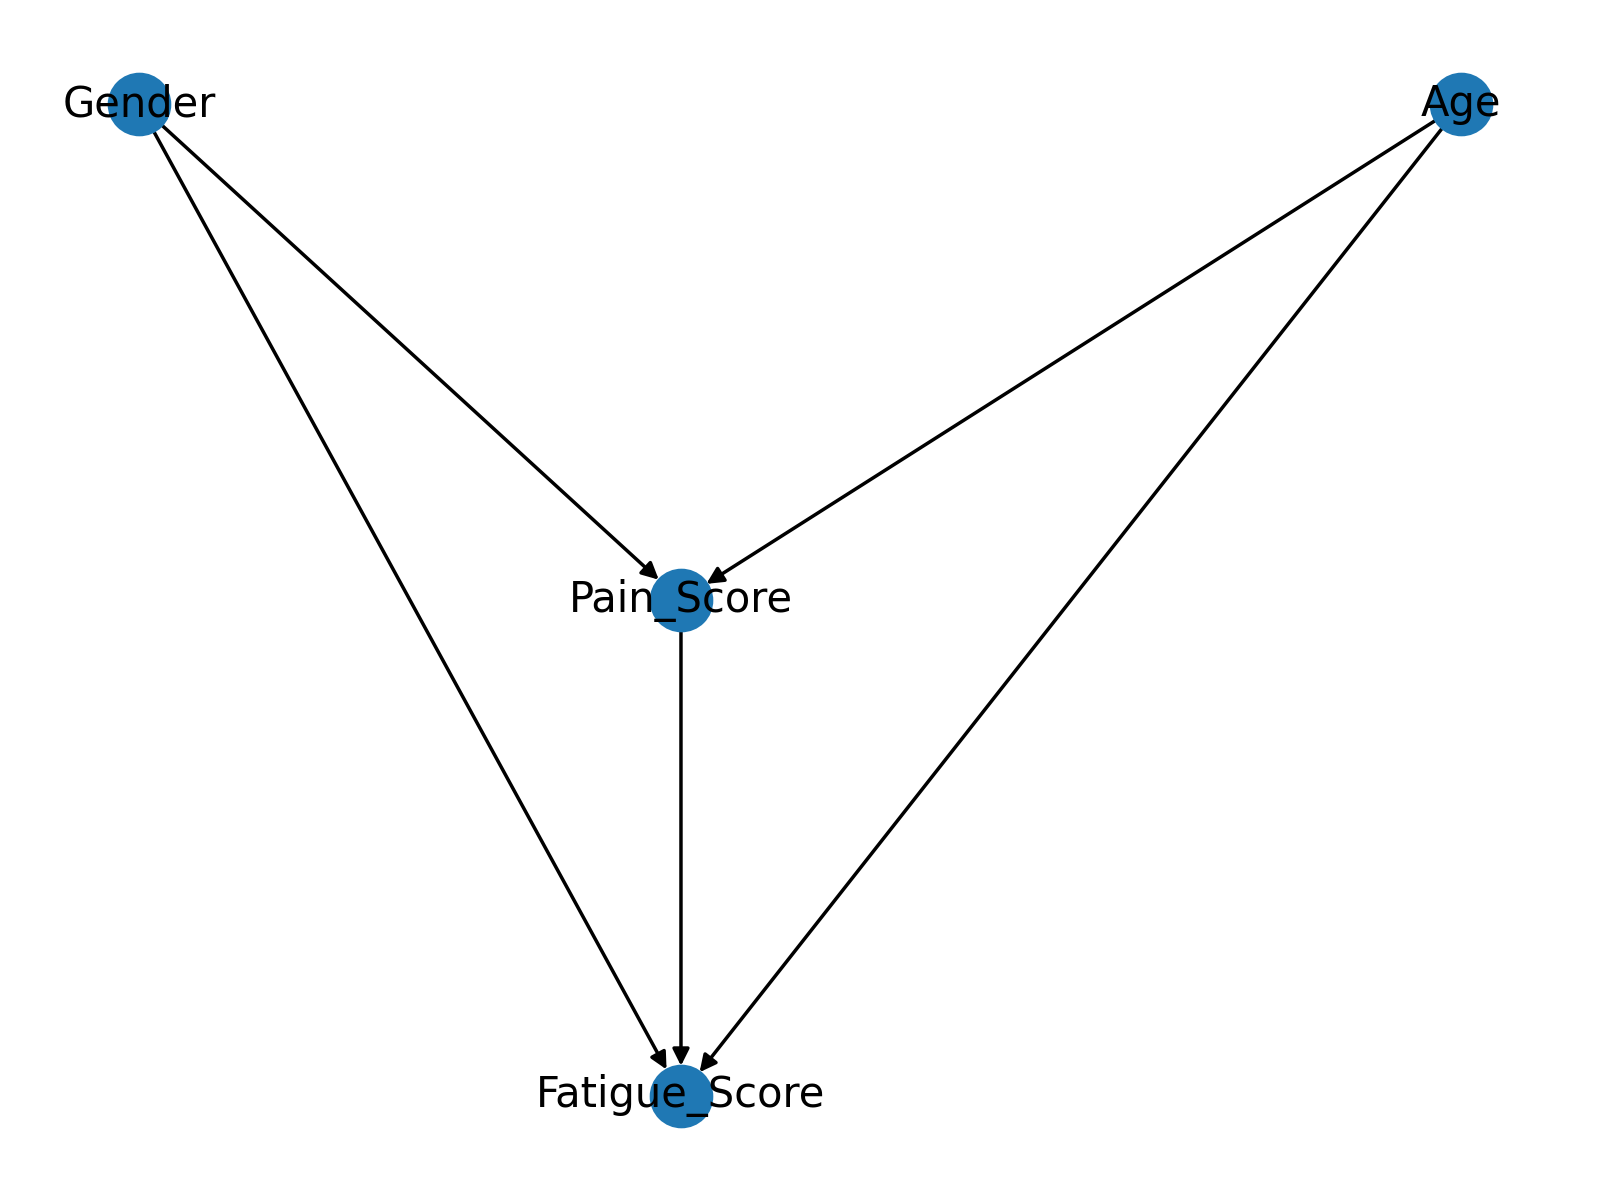

In [6]:
list_of_tup = [("Gender","Pain_Score"),  ("Gender","Fatigue_Score"),
               ("Age", "Pain_Score"),    ("Age","Fatigue_Score"),
               ("Pain_Score","Fatigue_Score")]
model = BayesianModel(list_of_tup)
%matplotlib notebook
#Draw
# nx.draw(model, with_labels=True)
# plt.show()
pos = graphviz_layout(model, prog = 'dot')
nx.draw(model,with_labels=True, pos = pos)

### Training Model

#### 1. On all daytime intervals

In [7]:
model.fit(training_df, estimator=BayesianEstimator)
cpd_pain = model.get_cpds('Pain_Score')
cpd_fatigue = model.get_cpds('Fatigue_Score')

#### 2. Only on 'wake' daytime interval

In [ ]:
model.fit(wake_df, estimator=BayesianEstimator)

### Validation using joint probability

In [8]:
infer = VariableElimination(model)

In [9]:
test = infer.query(['Gender','Age','Pain_Score', "Fatigue_Score"], joint = True, show_progress=False)

### CPDS for all variables

In [10]:
print(model.get_cpds("Age"))

+-----------------------+----------+
| Age(60 and Older)     | 0.103111 |
+-----------------------+----------+
| Age(Between 30 to 60) | 0.775111 |
+-----------------------+----------+
| Age(Younger than 30)  | 0.121778 |
+-----------------------+----------+


In [11]:
print(model.get_cpds("Gender"))

+----------------+----------+
| Gender(Female) | 0.691333 |
+----------------+----------+
| Gender(Male)   | 0.308667 |
+----------------+----------+


In [12]:
#Nested dictionary:
nested_dict = model.get_cpds("Fatigue_Score").name_to_no
nested_dict

age_dict = dict((v,k) for k,v in nested_dict["Age"].items())
gender_dict = dict((v,k) for k,v in nested_dict["Gender"].items())
fatigue_dict = dict((v,k) for k,v in nested_dict["Fatigue_Score"].items())
pain_dict = dict((v,k) for k,v in nested_dict["Pain_Score"].items())


### Dataframe of Joint Probabilities

In [13]:
col = test.variables
age,pain,gender,fatigue = test.values.shape
joint_proba_df = pd.DataFrame(columns = col)
index = 0
predict_dict = {}

In [14]:
for a in range(age):
    for p in range(pain):
        for g in range(gender):
            for f in range(fatigue):
                joint_proba_df.loc[index, col[0]] = a
                joint_proba_df.loc[index, col[1]] = p
                joint_proba_df.loc[index, col[2]] = g
                joint_proba_df.loc[index, col[3]] = f
                joint_proba_df.loc[index, "Phi"] = test.values[a, p, g, f]
                index+=1
                
joint_proba_df["Age"].replace(age_dict, inplace=True)
joint_proba_df["Pain_Score"].replace(pain_dict, inplace=True)
joint_proba_df["Gender"].replace(gender_dict, inplace=True)
joint_proba_df["Fatigue_Score"].replace(fatigue_dict, inplace=True)

In [132]:
joint_proba_df

,Pain_Score,Age,Gender,Fatigue_Score,Phi
0,Higher,60 and Older,Female,Higher,0.002722
1,Higher,60 and Older,Female,Lower,0.001032
2,Higher,60 and Older,Female,Normal,0.004751
3,Higher,60 and Older,Female,Not Recorded,0.000018
4,Higher,60 and Older,Male,Higher,0.001638
5,Higher,60 and Older,Male,Lower,0.000733
6,Higher,60 and Older,Male,Normal,0.001638
7,Higher,60 and Older,Male,Not Recorded,0.000009
8,Higher,Between 30 to 60,Female,Higher,0.039065
9,Higher,Between 30 to 60,Female,Lower,0.008985


### Creating initial_state_dist array

In [18]:
full_copy = data_full.copy()
full_copy.drop_duplicates(keep=False,inplace=True) 
full_copy

,Patient_ID,Gender,Age,Daytime_Interval,Patient_Interval_Number,Pain_Score,Action_Pain,Fatigue_Score,Action_Fatigue,Last_Activitybout_State,Current_Activitybout_Action,EOD_PAW,Action_PAW
0,1001,Female,Between 30 to 60,Wake,1,Higher,Recorded,Normal,Recorded,Not Recorded,Higher,None,None
1,1001,Female,Between 30 to 60,Morning,2,Lower,Recorded,Lower,Recorded,Higher,Normal,None,None
2,1001,Female,Between 30 to 60,Afternoon,3,Higher,Recorded,Normal,Recorded,Normal,Higher,None,None
3,1001,Female,Between 30 to 60,Evening,4,Higher,Recorded,Higher,Recorded,Higher,Lower,None,Recorded
4,1001,Female,Between 30 to 60,Bed,5,Normal,Recorded,Higher,Recorded,Lower,Lower,Normal,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3740,1110,Female,Between 30 to 60,Wake,31,Not Recorded,Recorded,Not Recorded,Recorded,Higher,Lower,None,None
3741,1110,Female,Between 30 to 60,Morning,32,Lower,Recorded,Higher,Recorded,Lower,Lower,None,None
3742,1110,Female,Between 30 to 60,Afternoon,33,Higher,Not Recorded,Normal,Not Recorded,Lower,Higher,None,None
3743,1110,Female,Between 30 to 60,Evening,34,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Higher,Lower,None,Not Recorded


### State Order

In [78]:
initial_state_dist = np.load('../initial_state_dist.npy')
state_feature = np.load('../state_feature.npy')
state_feature_name = np.load('../state_feature_name.npy')

In [120]:
#Count the number of cells in array that are non-zero:
# np.count_nonzero(initial_state_dist)

In [79]:
print(state_feature.shape)

(3072, 26)


In [80]:
print(state_feature_name)

['Gender:Male' 'Gender:Female' 'Age:Younger Than 30'
 'Age:Between 30 To 60' 'Age:60 And Older' 'Current Daytime Interval:Wake'
 'Current Daytime Interval:Morning' 'Current Daytime Interval:Afternoon'
 'Current Daytime Interval:Evening' 'Current Daytime Interval:Bed'
 'Current Interval Pain Score:Lower' 'Current Interval Pain Score:Normal'
 'Current Interval Pain Score:Higher'
 'Current Interval Pain Score:Not Recorded'
 'Current Interval Fatigue Score:Lower'
 'Current Interval Fatigue Score:Normal'
 'Current Interval Fatigue Score:Higher'
 'Current Interval Fatigue Score:Not Recorded'
 'Last Interval Activity Bouts:Lower'
 'Last Interval Activity Bouts:Normal'
 'Last Interval Activity Bouts:Higher'
 'Last Interval Activity Bouts:Not Recorded'
 'Eod Positive Affect And Well-Being:Lower'
 'Eod Positive Affect And Well-Being:Normal'
 'Eod Positive Affect And Well-Being:Higher'
 'Eod Positive Affect And Well-Being:Not Recorded']


In [81]:
col = np.append(state_feature_name, 'Probability')
prob = np.zeros((state_feature.shape[0],1))
data = np.hstack((state_feature,prob))

state_distribution_df = pd.DataFrame(data=data, columns = col)
state_distribution_df

,Gender:Male,Gender:Female,Age:Younger Than 30,Age:Between 30 To 60,Age:60 And Older,Current Daytime Interval:Wake,Current Daytime Interval:Morning,Current Daytime Interval:Afternoon,Current Daytime Interval:Evening,Current Daytime Interval:Bed,...,Current Interval Fatigue Score:Not Recorded,Last Interval Activity Bouts:Lower,Last Interval Activity Bouts:Normal,Last Interval Activity Bouts:Higher,Last Interval Activity Bouts:Not Recorded,Eod Positive Affect And Well-Being:Lower,Eod Positive Affect And Well-Being:Normal,Eod Positive Affect And Well-Being:Higher,Eod Positive Affect And Well-Being:Not Recorded,Probability
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3068,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3069,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3070,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [168]:
wake_df = state_distribution_df.loc[state_distribution_df['Current Daytime Interval:Wake'] == 1.0]
wake_df =  wake_df.loc[wake_df['Last Interval Activity Bouts:Not Recorded'] == 1.0]                                    

wake_df

,Gender:Male,Gender:Female,Age:Younger Than 30,Age:Between 30 To 60,Age:60 And Older,Current Daytime Interval:Wake,Current Daytime Interval:Morning,Current Daytime Interval:Afternoon,Current Daytime Interval:Evening,Current Daytime Interval:Bed,Current Interval Pain Score:Lower,Current Interval Pain Score:Normal,Current Interval Pain Score:Higher,Current Interval Pain Score:Not Recorded,Current Interval Fatigue Score:Lower,Current Interval Fatigue Score:Normal,Current Interval Fatigue Score:Higher,Current Interval Fatigue Score:Not Recorded,Last Interval Activity Bouts:Lower,Last Interval Activity Bouts:Normal,Last Interval Activity Bouts:Higher,Last Interval Activity Bouts:Not Recorded,Eod Positive Affect And Well-Being:Lower,Eod Positive Affect And Well-Being:Normal,Eod Positive Affect And Well-Being:Higher,Eod Positive Affect And Well-Being:Not Recorded,Probability
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
27,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
35,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
39,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [210]:
wake_reduced_df = wake_df[original_columns[:-1]] 
wake_reduced_df

,Gender:Male,Gender:Female,Age:Younger Than 30,Age:Between 30 To 60,Age:60 And Older,Current Interval Pain Score:Lower,Current Interval Pain Score:Normal,Current Interval Pain Score:Higher,Current Interval Pain Score:Not Recorded,Current Interval Fatigue Score:Lower,Current Interval Fatigue Score:Normal,Current Interval Fatigue Score:Higher,Current Interval Fatigue Score:Not Recorded
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
23,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
27,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
31,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
35,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
39,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [192]:
len(wake_reduced_df.index)

96

In [193]:
indices = wake_reduced_df.index
indices #The probability of these indices is to be updated in the state_distribution_df

Int64Index([   3,    7,   11,   15,   19,   23,   27,   31,   35,   39,   43,
              47,   51,   55,   59,   63,  515,  519,  523,  527,  531,  535,
             539,  543,  547,  551,  555,  559,  563,  567,  571,  575, 1027,
            1031, 1035, 1039, 1043, 1047, 1051, 1055, 1059, 1063, 1067, 1071,
            1075, 1079, 1083, 1087, 1539, 1543, 1547, 1551, 1555, 1559, 1563,
            1567, 1571, 1575, 1579, 1583, 1587, 1591, 1595, 1599, 2051, 2055,
            2059, 2063, 2067, 2071, 2075, 2079, 2083, 2087, 2091, 2095, 2099,
            2103, 2107, 2111, 2563, 2567, 2571, 2575, 2579, 2583, 2587, 2591,
            2595, 2599, 2603, 2607, 2611, 2615, 2619, 2623],
           dtype='int64')

### One Hot Encoding of Joint Probability Dataframe

In [199]:
one_hot_df = pd.get_dummies(joint_proba_df, prefix_sep=':',dtype=float)
one_hot_df.columns

Index(['Phi', 'Pain_Score:Higher', 'Pain_Score:Lower', 'Pain_Score:Normal',
       'Pain_Score:Not Recorded', 'Age:60 and Older', 'Age:Between 30 to 60',
       'Age:Younger than 30', 'Gender:Female', 'Gender:Male',
       'Fatigue_Score:Higher', 'Fatigue_Score:Lower', 'Fatigue_Score:Normal',
       'Fatigue_Score:Not Recorded'],
      dtype='object')

In [200]:
one_hot_df

,Phi,Pain_Score:Higher,Pain_Score:Lower,Pain_Score:Normal,Pain_Score:Not Recorded,Age:60 and Older,Age:Between 30 to 60,Age:Younger than 30,Gender:Female,Gender:Male,Fatigue_Score:Higher,Fatigue_Score:Lower,Fatigue_Score:Normal,Fatigue_Score:Not Recorded
0,0.002722,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.001032,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.004751,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.000018,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.001638,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5,0.000733,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6,0.001638,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,0.000009,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8,0.039065,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9,0.008985,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [201]:
#Reorder and Rename:
new_columns = ['Gender:Male', 'Gender:Female',
 
 'Age:Younger than 30','Age:Between 30 to 60', 'Age:60 and Older',
 
 'Pain_Score:Lower', 'Pain_Score:Normal',
 'Pain_Score:Higher','Pain_Score:Not Recorded',
 
 'Fatigue_Score:Lower','Fatigue_Score:Normal',
 'Fatigue_Score:Higher','Fatigue_Score:Not Recorded',
               'Phi'
]

original_columns = ['Gender:Male', 'Gender:Female',
 
 'Age:Younger Than 30','Age:Between 30 To 60', 'Age:60 And Older',
 
 'Current Interval Pain Score:Lower', 'Current Interval Pain Score:Normal',
 'Current Interval Pain Score:Higher','Current Interval Pain Score:Not Recorded',
 
 'Current Interval Fatigue Score:Lower','Current Interval Fatigue Score:Normal',
 'Current Interval Fatigue Score:Higher','Current Interval Fatigue Score:Not Recorded',
                    
                    'Probability'
]

rename = dict(zip(new_columns,original_columns))
reorder_df = one_hot_df.reindex(columns=new_columns)
reorder_df

,Gender:Male,Gender:Female,Age:Younger than 30,Age:Between 30 to 60,Age:60 and Older,Pain_Score:Lower,Pain_Score:Normal,Pain_Score:Higher,Pain_Score:Not Recorded,Fatigue_Score:Lower,Fatigue_Score:Normal,Fatigue_Score:Higher,Fatigue_Score:Not Recorded,Phi
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.002722
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.001032
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.004751
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000018
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.001638
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000733
6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.001638
7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000009
8,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.039065
9,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.008985


In [212]:
rename_df = reorder_df.rename(columns=rename)
compare_df = rename_df.drop(labels='Probability', axis=1)
compare_df

,Gender:Male,Gender:Female,Age:Younger Than 30,Age:Between 30 To 60,Age:60 And Older,Current Interval Pain Score:Lower,Current Interval Pain Score:Normal,Current Interval Pain Score:Higher,Current Interval Pain Score:Not Recorded,Current Interval Fatigue Score:Lower,Current Interval Fatigue Score:Normal,Current Interval Fatigue Score:Higher,Current Interval Fatigue Score:Not Recorded
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


### Match Rows of two dataframes:

In [ ]:
datadf = pd.DataFrame([['USA','Business1'],['AUS','Business2'],['UK','Business3'],['IND','Business4']],
                          columns=['country','business'])
configdf = pd.DataFrame([['AUS','Business2'],['IND','Business4'],['USA','Business1'],['UK','Business3']],
                          columns=['country','business'])
datadf['new_col'] = datadf.apply(lambda x: (np.where((x['country'] == configdf['country']) & (x['business'] == configdf['business']))[0][0]),axis=1)
